# Statistic Analysis

#### Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, hour, weekofyear, dayofweek
from pyspark.sql.functions import col, corr
import scipy
import matplotlib.pyplot as plt
import pyspark.sql.functions as F


#### Load Data

In [2]:
# Create spark session
spark = SparkSession.builder \
    .appName("Statistic analysis") \
    .getOrCreate()

# Load data from csv file
df_yearly_prices = spark.read.csv("../Data/df_yearly_prices.csv", header=True, inferSchema=True)


#### Descriptive Statistics

In [3]:
# Mean, standard deviation, min, max, count
df_yearly_prices.describe().show()

+-------+------------------+----------+
|summary|             value|percentage|
+-------+------------------+----------+
|  count|              8760|      8760|
|   mean| 287.2879977168955|       1.0|
| stddev|106.08502682607529|       0.0|
|    min|             11.68|         1|
|    max|            954.01|         1|
+-------+------------------+----------+



In [4]:
# Quantile 0.25, 0.5, 0.75
df_yearly_prices.approxQuantile("value", [0.25, 0.5, 0.75], 0.0)

[223.94, 283.99, 346.9]

#### Data distribution

<Axes: >

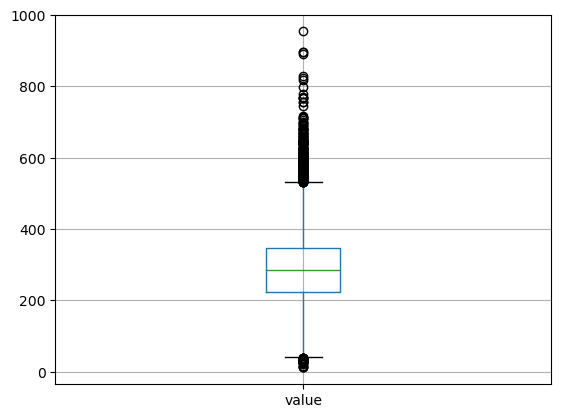

In [5]:
# boxplot
df_yearly_prices.select("value").toPandas().boxplot()

In [36]:
# outliers detection using dispersion method (IQR)
q1, q3 = df_yearly_prices.approxQuantile("value", [0.25, 0.75], 0.0)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_outliers = df_yearly_prices.filter((df_yearly_prices.value < lower_bound) | (df_yearly_prices.value > upper_bound))

# create a new dataframe without outliers
df_yearly_prices_no_outliers = df_yearly_prices.filter((df_yearly_prices.value >= lower_bound) & (df_yearly_prices.value <= upper_bound))

df_yearly_prices_no_outliers.toPandas().to_csv("../Data/df_yearly_prices_no_outliers.csv")

c:\Users\Usuario\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


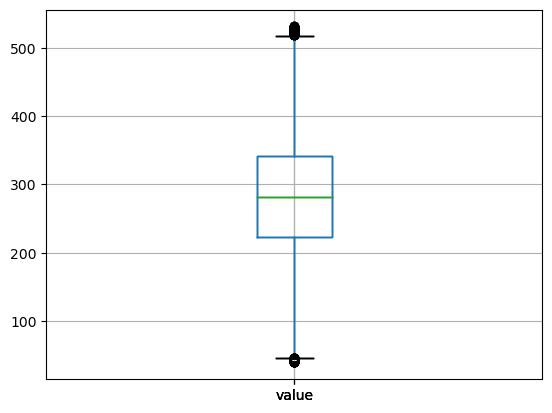

In [29]:
# boxplot without outliers
df_yearly_prices_no_outliers.select("value").toPandas().boxplot()
plt

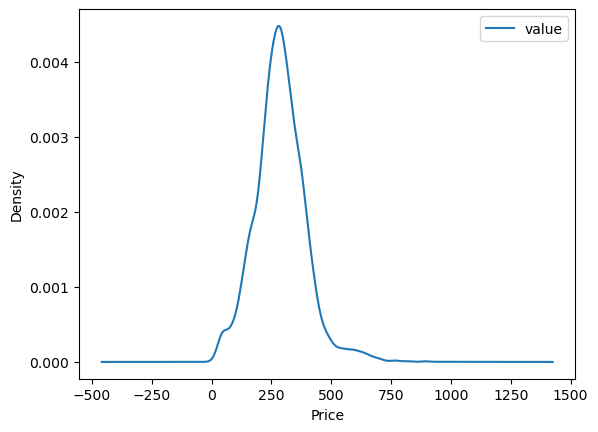

In [6]:
# density graph (histogram)
df_yearly_prices.select("value").toPandas().plot(kind='density').set_xlabel("Price")
plt.show()

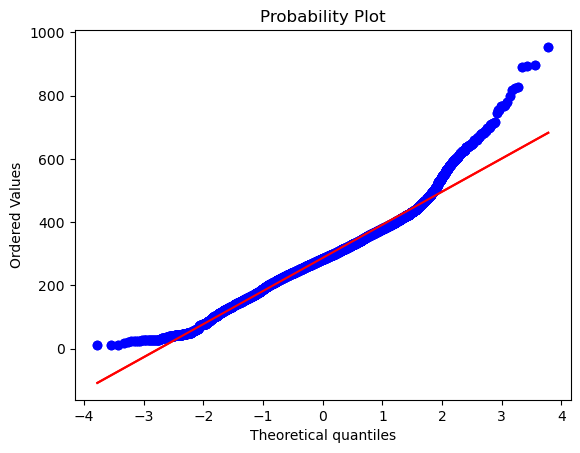

In [ ]:
# P-P plot
scipy.stats.probplot(df_yearly_prices.select("value").toPandas().value, dist="norm", plot=plt)
plt.show()

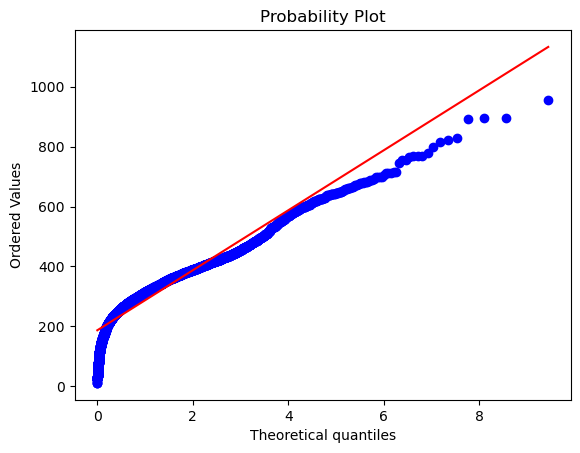

In [ ]:
# exponential distribution
scipy.stats.probplot(df_yearly_prices.select("value").toPandas().value, dist="expon", plot=plt)
plt.show() 


In [ ]:
# shapiro test and anderson test
df_yearly_prices.select("value").rdd.flatMap(lambda x: x).pipe(scipy.stats.shapiro).collect()
df_yearly_prices.select("value").rdd.flatMap(lambda x: x).pipe(scipy.stats.anderson).collect()

#### Correlation Analysis

In [39]:
# make new columns for year, month, week, day, weekday and hour
df_yearly_prices = df_yearly_prices.withColumn("year", year(df_yearly_prices["datetime"]))
df_yearly_prices = df_yearly_prices.withColumn("month", month(df_yearly_prices["datetime"]))
df_yearly_prices = df_yearly_prices.withColumn("week", weekofyear(df_yearly_prices["datetime"]))
df_yearly_prices = df_yearly_prices.withColumn("day", dayofweek(df_yearly_prices["datetime"]))
df_yearly_prices = df_yearly_prices.withColumn("hour", hour(df_yearly_prices["datetime"]))
df_yearly_prices = df_yearly_prices.withColumn("weekday", (dayofweek(df_yearly_prices["datetime"]) >= 2) & (dayofweek(df_yearly_prices["datetime"]) <= 6))

# transform boolean to int for weekday column (True = 1, False = 0)
df_yearly_prices = df_yearly_prices.withColumn("weekday", df_yearly_prices["weekday"].cast("int"))
df_yearly_prices.toPandas().to_csv("../Data/df_yearly_prices_extra.csv")

c:\Users\Usuario\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [37]:
# correlation matrix graph between value and year, month, week, day, hour, weekday
df_yearly_prices.select("value", "year", "month", "week", "day", "hour", "weekday").toPandas().corr().style.background_gradient(cmap='coolwarm')



c:\Users\Usuario\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Usuario\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,value,year,month,week,day,hour,weekday
value,1.000000,nan,-0.251669,-0.277375,0.005728,0.118435,0.227278
year,nan,nan,nan,nan,nan,nan,nan
month,-0.251669,nan,1.000000,0.966496,0.012512,-0.000318,0.007066
week,-0.277375,nan,0.966496,1.000000,0.006580,-0.000323,-0.007676
day,0.005728,nan,0.012512,0.006580,1.000000,0.000000,-0.006456
hour,0.118435,nan,-0.000318,-0.000323,0.000000,1.000000,-0.000000
weekday,0.227278,nan,0.007066,-0.007676,-0.006456,-0.000000,1.000000


<Figure size 1000x600 with 0 Axes>

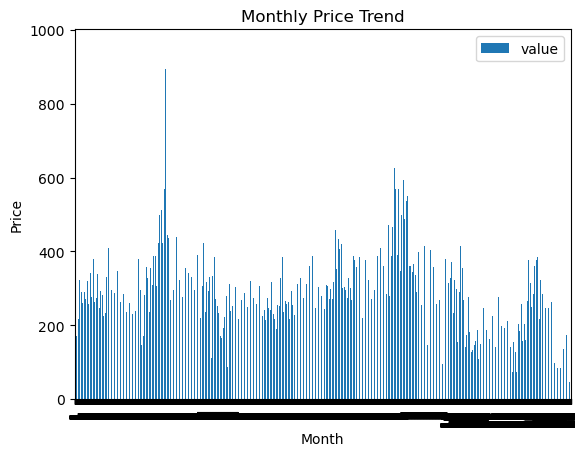

In [20]:
# dispersion graph
df_yearly_prices_graph = df_yearly_prices.withColumn("month", F.month("datetime"))
data = df_yearly_prices.select("month", "value").toPandas()

plt.figure(figsize=(10, 6))
data.plot(x="month", y="value", kind= 'bar')
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Monthly Price Trend")
plt.show()